# Лабораторная 1. Многослойный персептрон

**Выполнила Быковченко Софья, группа P4155**

Цель - создать архитектуру многослойного персептрона, классифицирующего грибы (mushroom_dataset).

Описание датасета - https://archive.ics.uci.edu/ml/datasets/Mushroom

- [x] 2 скрытых слоя, функция активации сигмоида, градиентный спуск без оптимизаторов

- [x] Выходных нейрона 2, по количеству классов

- [x] Обучить нейронную сеть

- [x] Посчитать accuracy, precision, recall, F1-меру

- [x] Вывести ROC-кривую

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import math
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

In [2]:
df = pd.read_csv('2. Mushroom_dataset', delimiter = ",", names=['class-label','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat'])
df

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BROWN,CLUSTERED,LEAVES
8412,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,SEVERAL,LEAVES
8413,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,CLUSTERED,LEAVES
8414,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,...,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BUFF,SEVERAL,LEAVES


## Описательная статистика

In [3]:
df['class-label'].value_counts()

class-label
EDIBLE       4488
POISONOUS    3928
Name: count, dtype: int64

In [4]:
# пропуски обозначим как NaN (в нашем случае ? — это пропуск)
df_clean = df.replace('?', np.nan)

L = len(df_clean)                         # общее число строк
CN = df_clean.count()                     # количество НЕпропущенных
NP = (L - CN) / L * 100                   # % пропущенных
P = df_clean.nunique()                    # мощность
MODE = df_clean.mode().iloc[0]            # самое частое значение (первый мод)


stats = pd.DataFrame({'Количество': CN, 'Процент пропусков': NP, 'Мощность': P, 'Самое частое значение': MODE}).T
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

In [5]:
def highlight_stats(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns, dtype='object')

    styles.loc['Мощность'] = df.loc['Мощность'].apply(lambda x: 'background-color: tomato' if x == 1 else '')
    
    missing = df.loc['Процент пропусков']
    styles.loc['Процент пропусков', missing == 0] = 'background-color: limegreen'
    mask_moderate = (missing > 0) & (missing < 30)
    styles.loc['Процент пропусков', mask_moderate] = 'background-color: steelblue'
    mask_high = missing >= 30
    styles.loc['Процент пропусков', mask_high] = 'background-color: tomato'
    
    return styles

In [6]:
styled_stats = stats.style.apply(highlight_stats, axis=None)
styled_stats

,class-label,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
Количество,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,5936,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
Процент пропусков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.467681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Мощность,2,6,4,10,2,9,2,2,2,12,2,4,4,4,9,9,1,4,3,5,9,6,7
Самое частое значение,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS


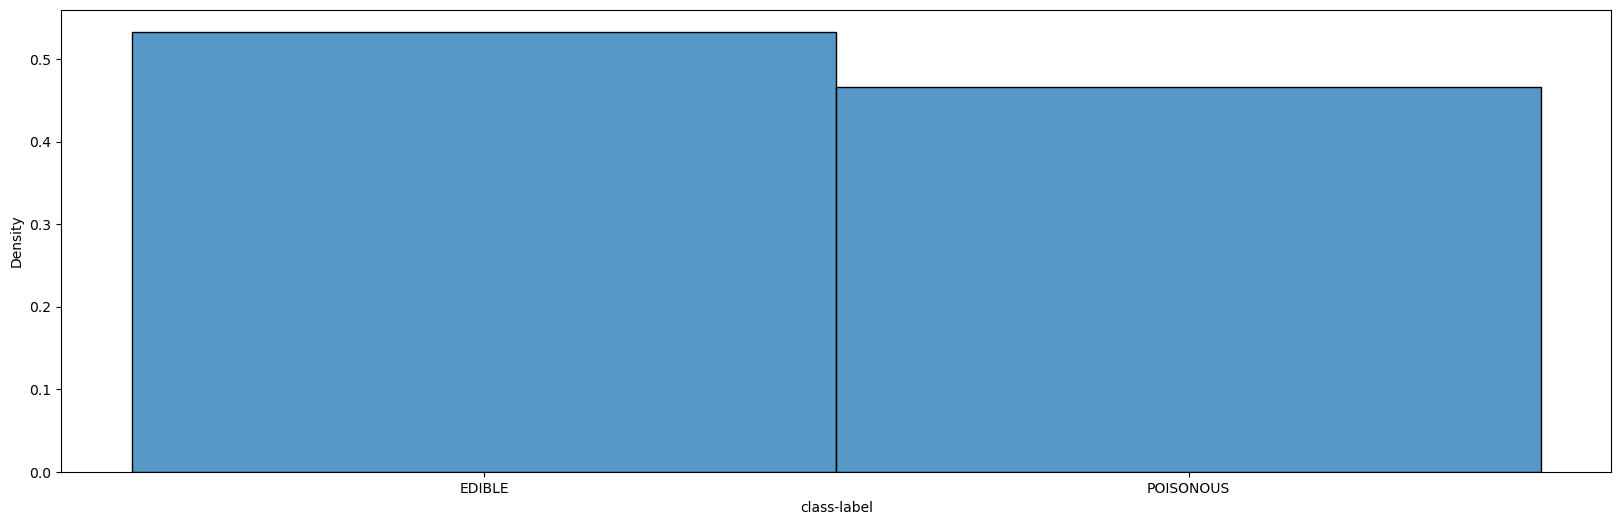

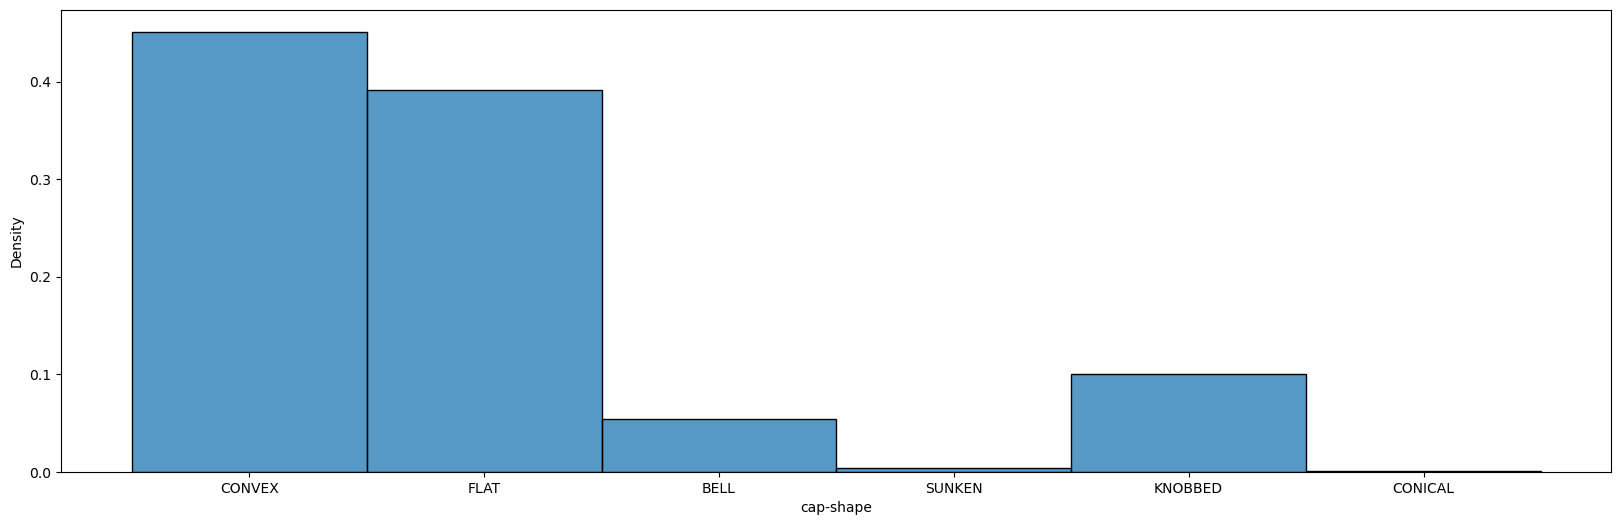

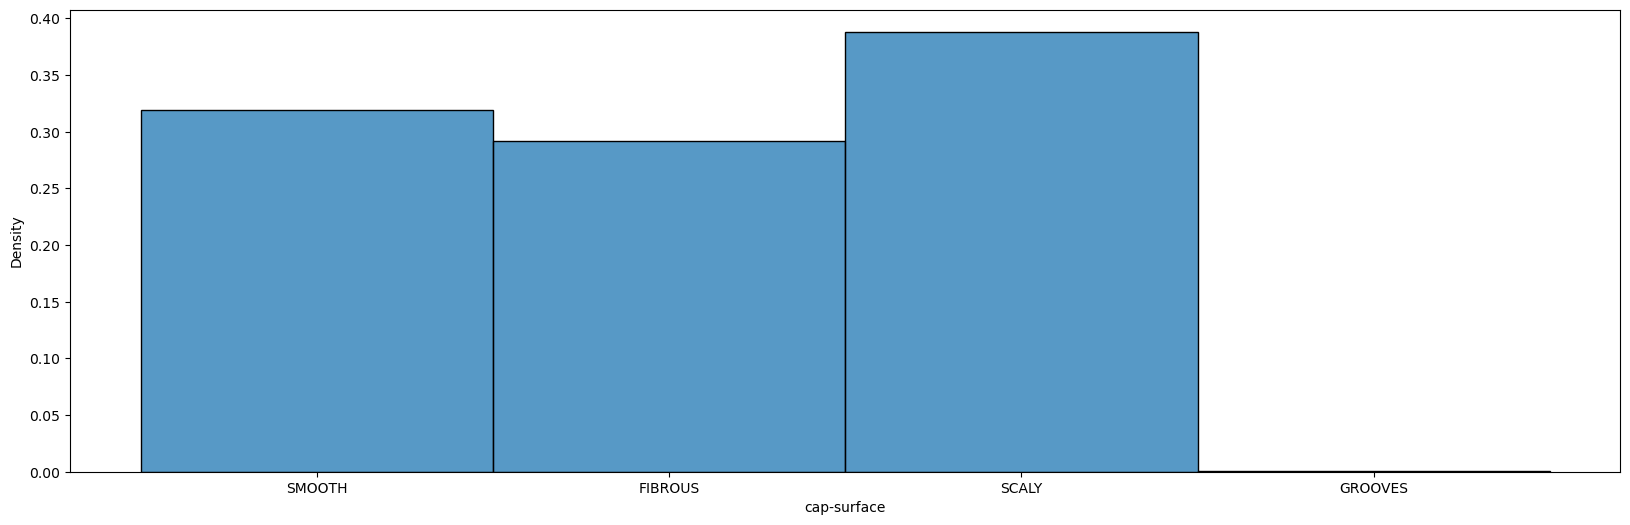

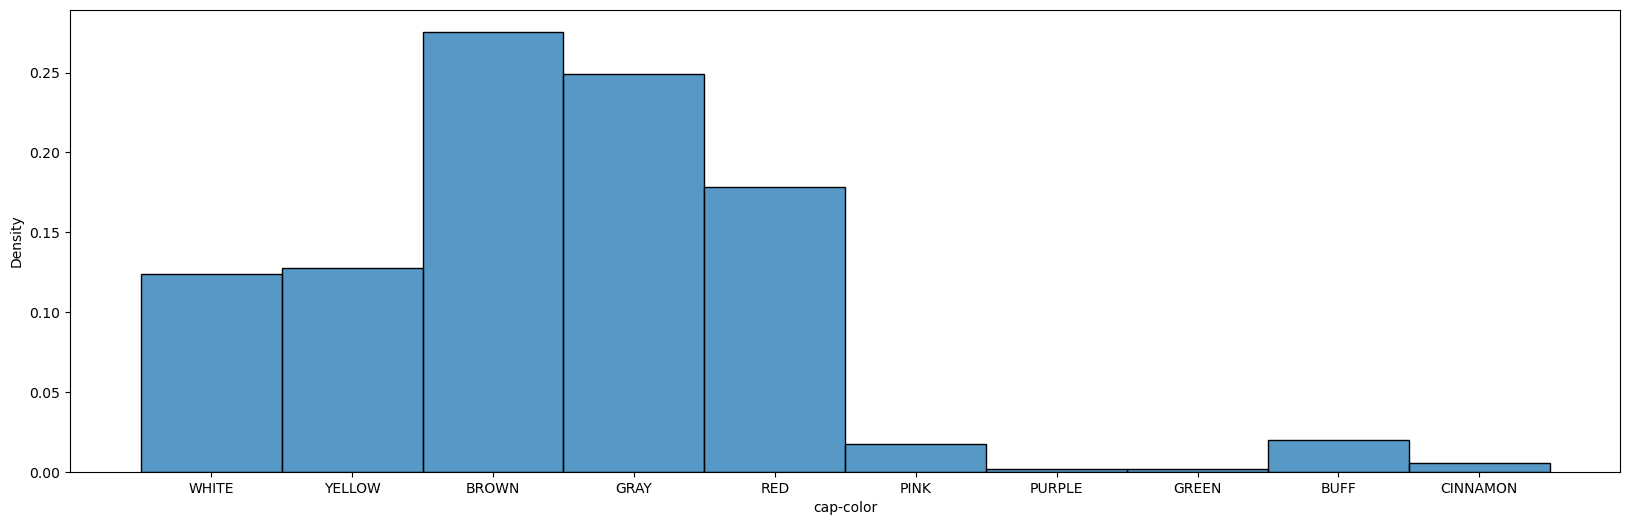

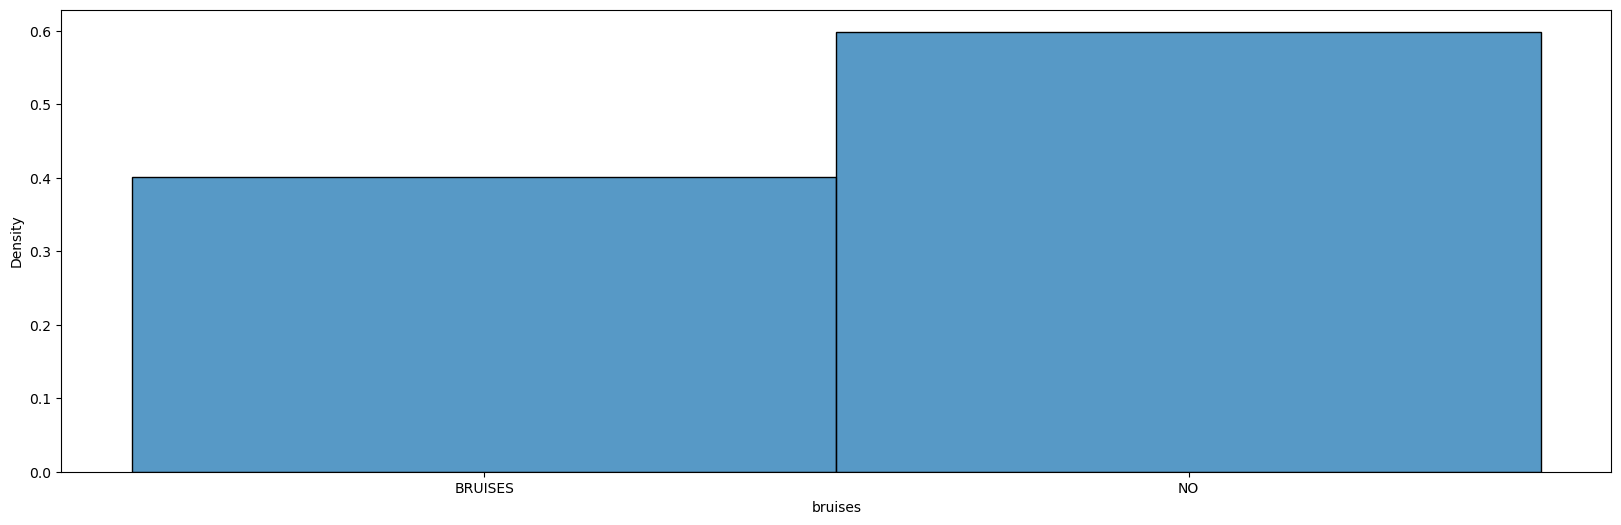

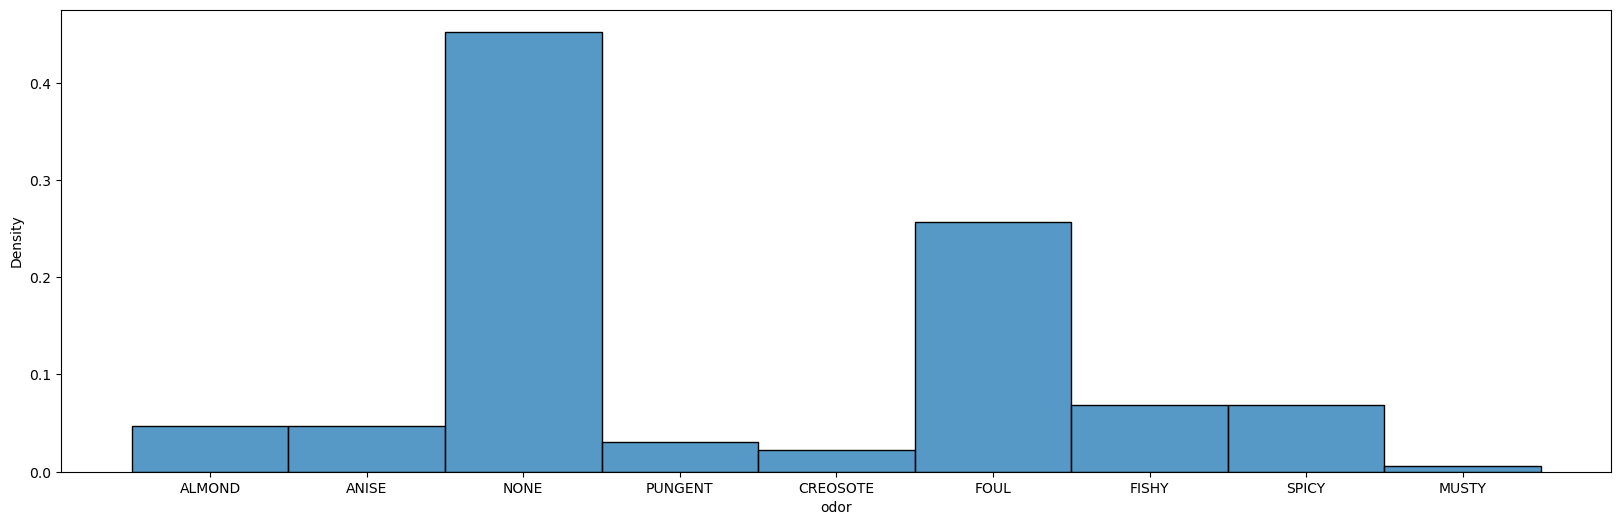

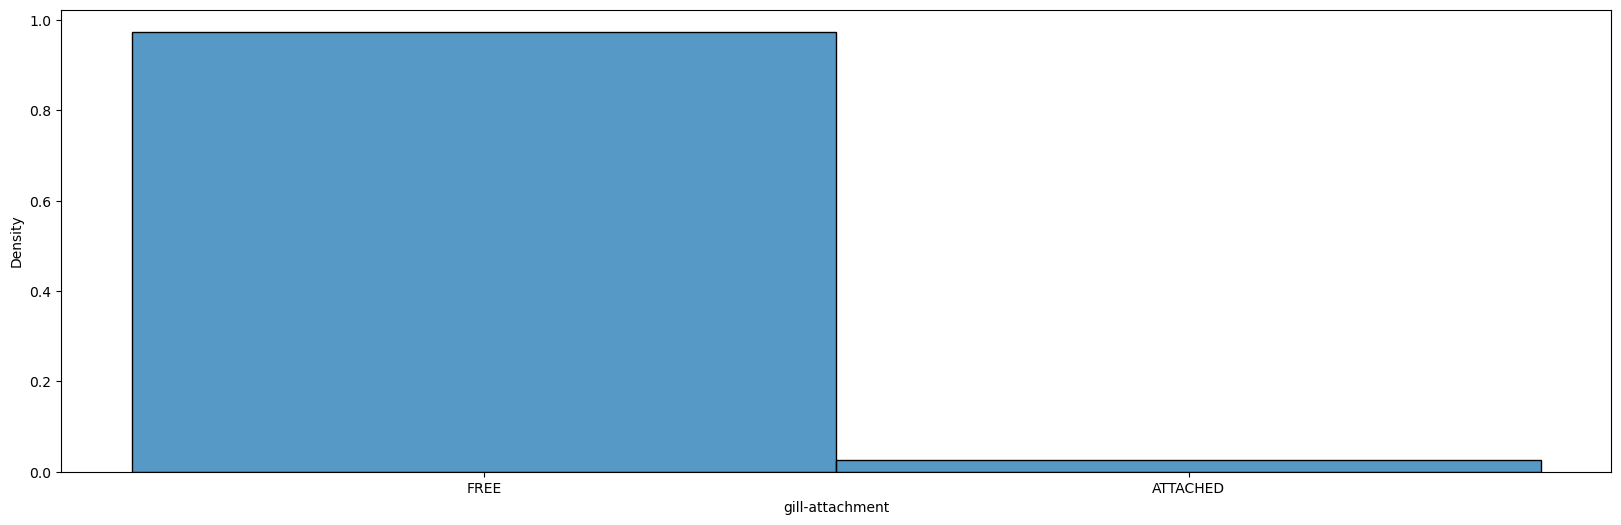

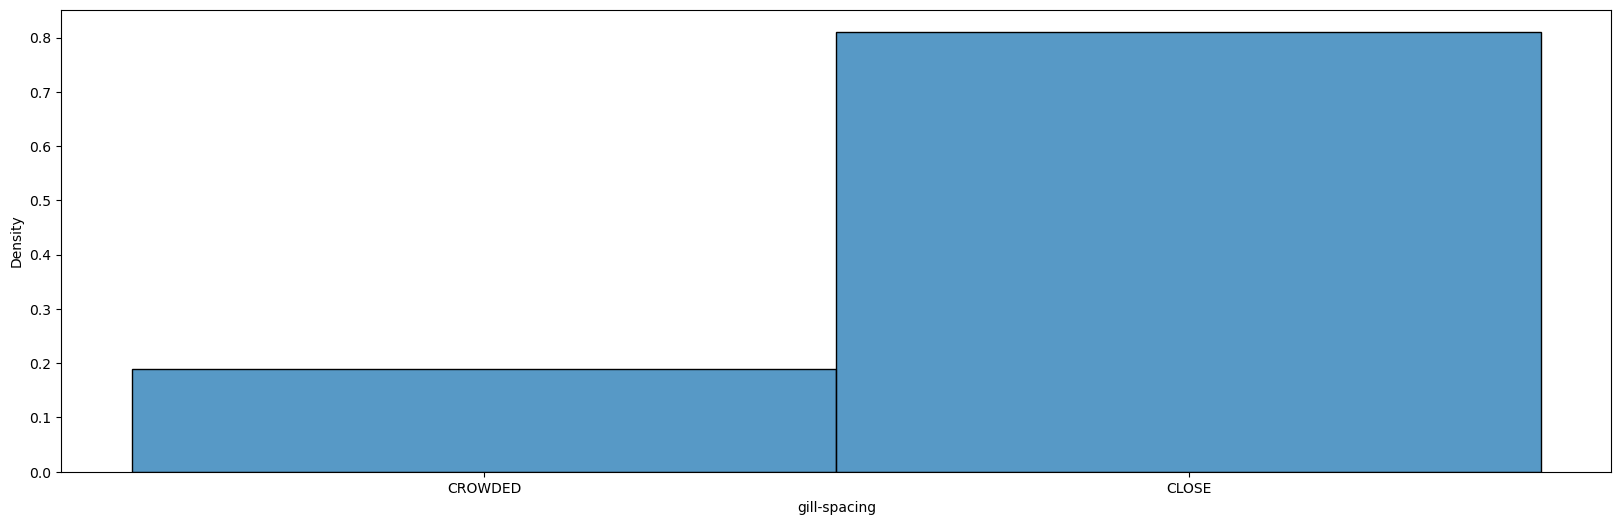

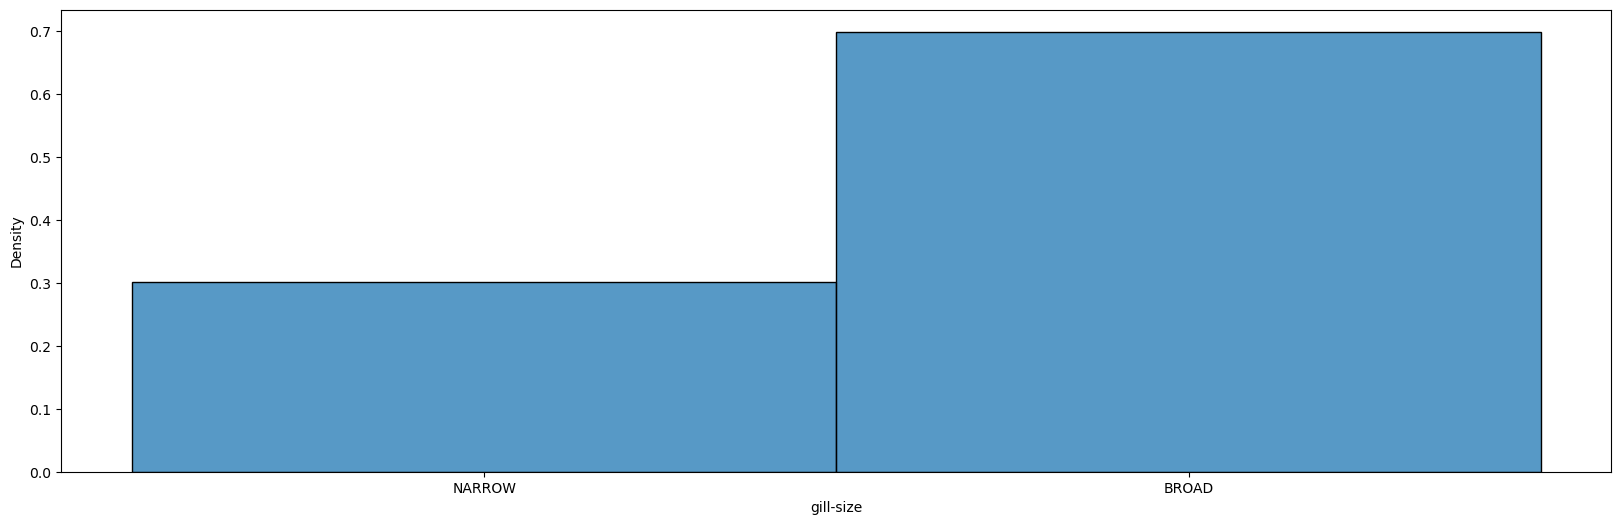

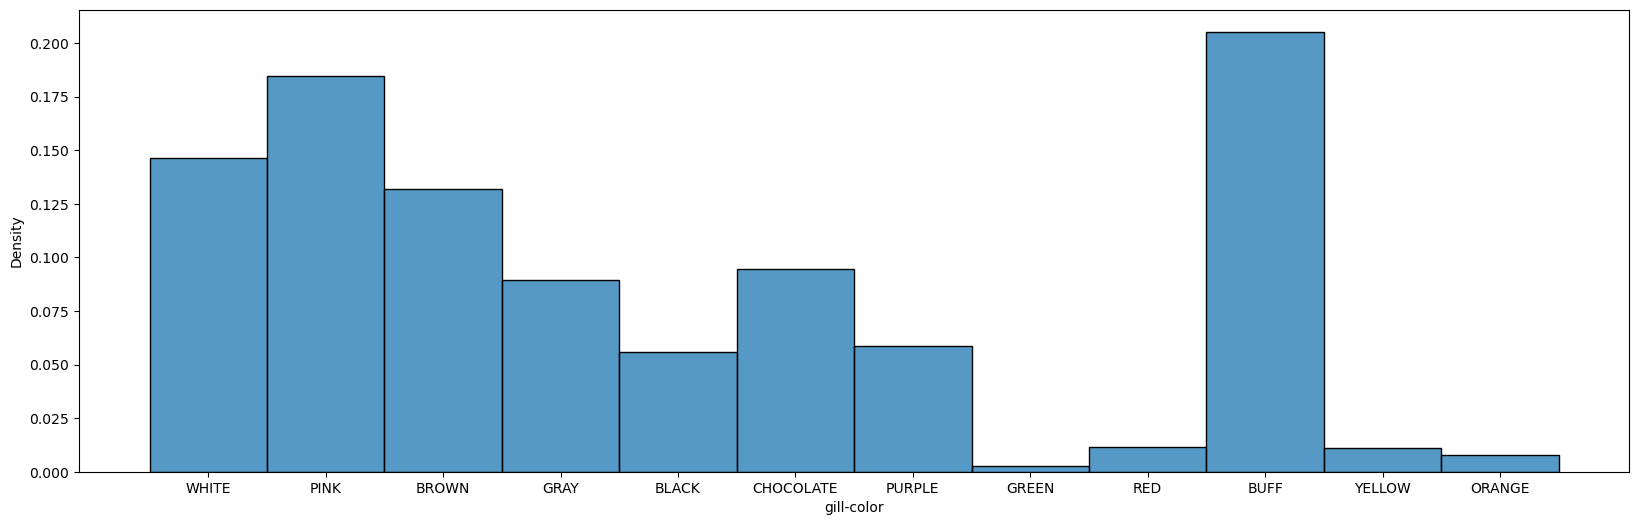

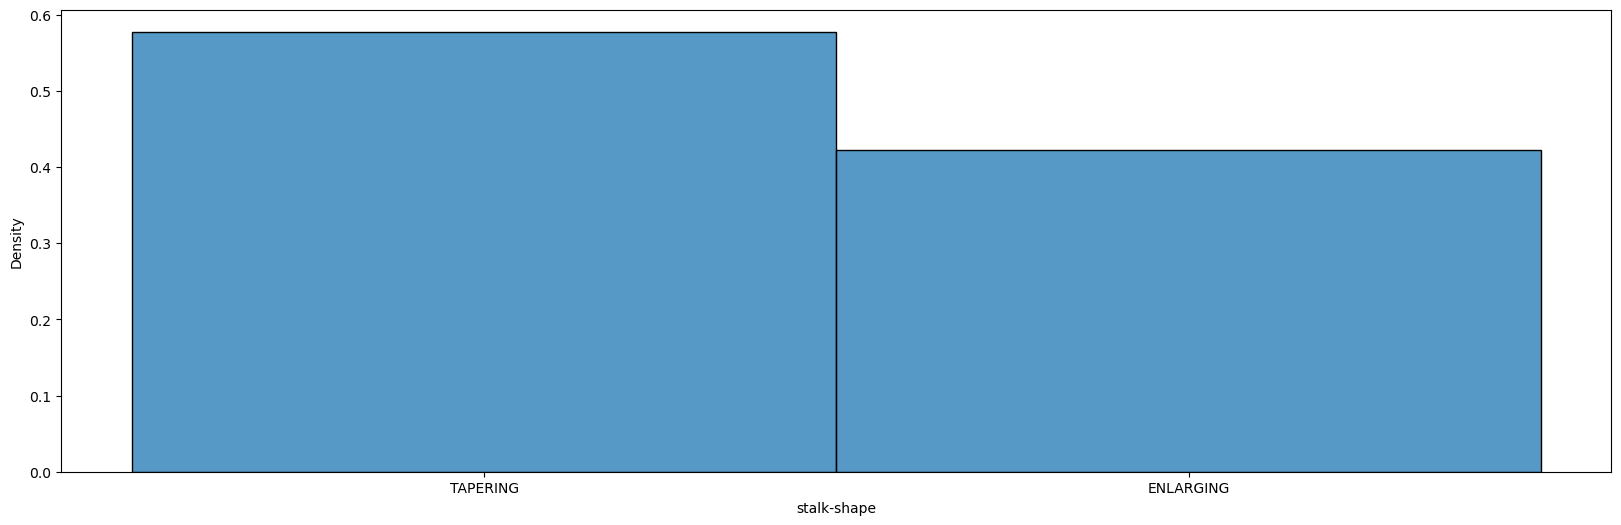

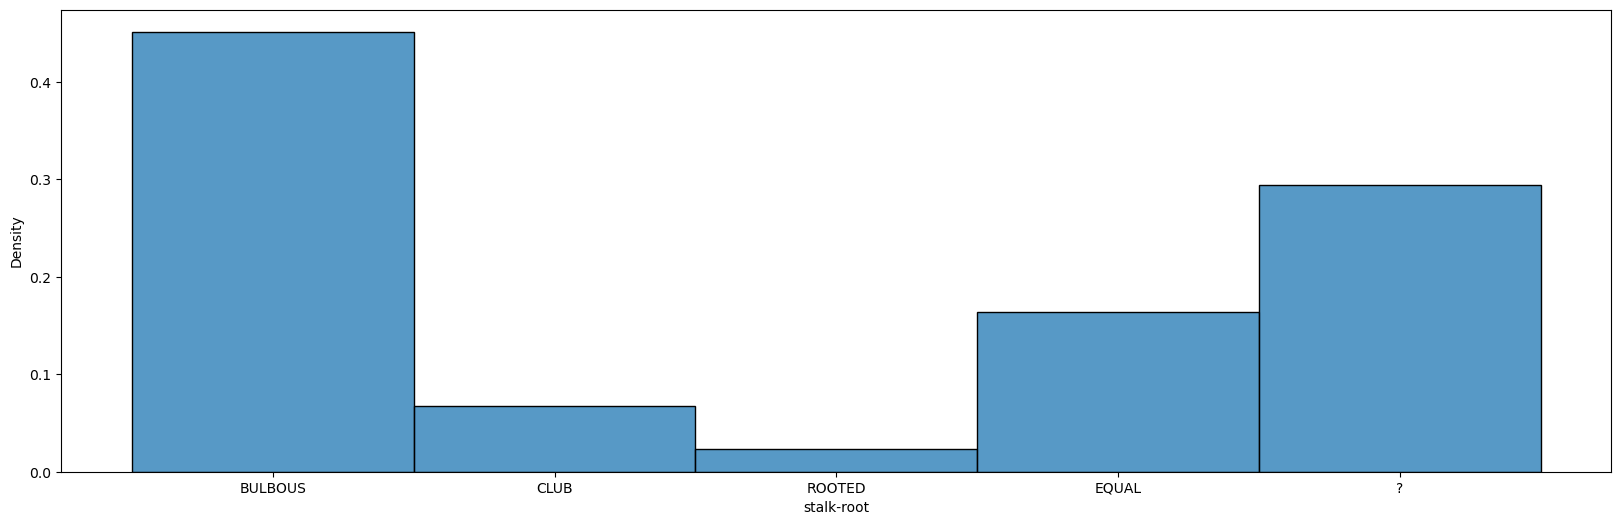

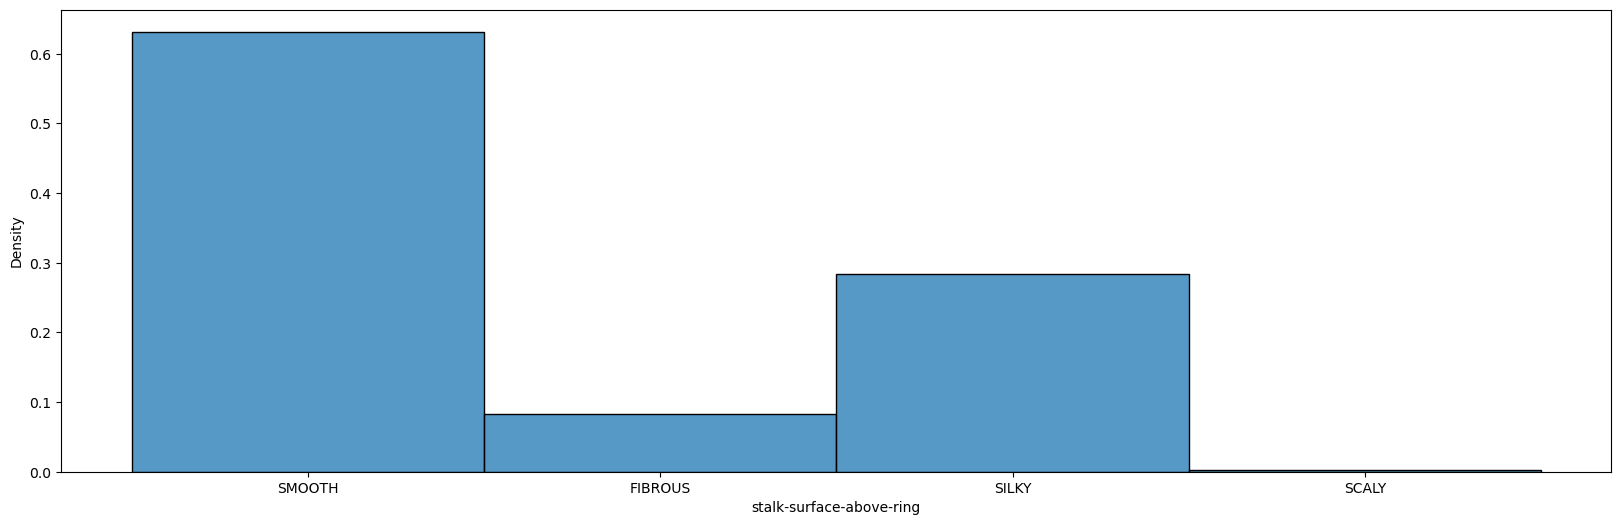

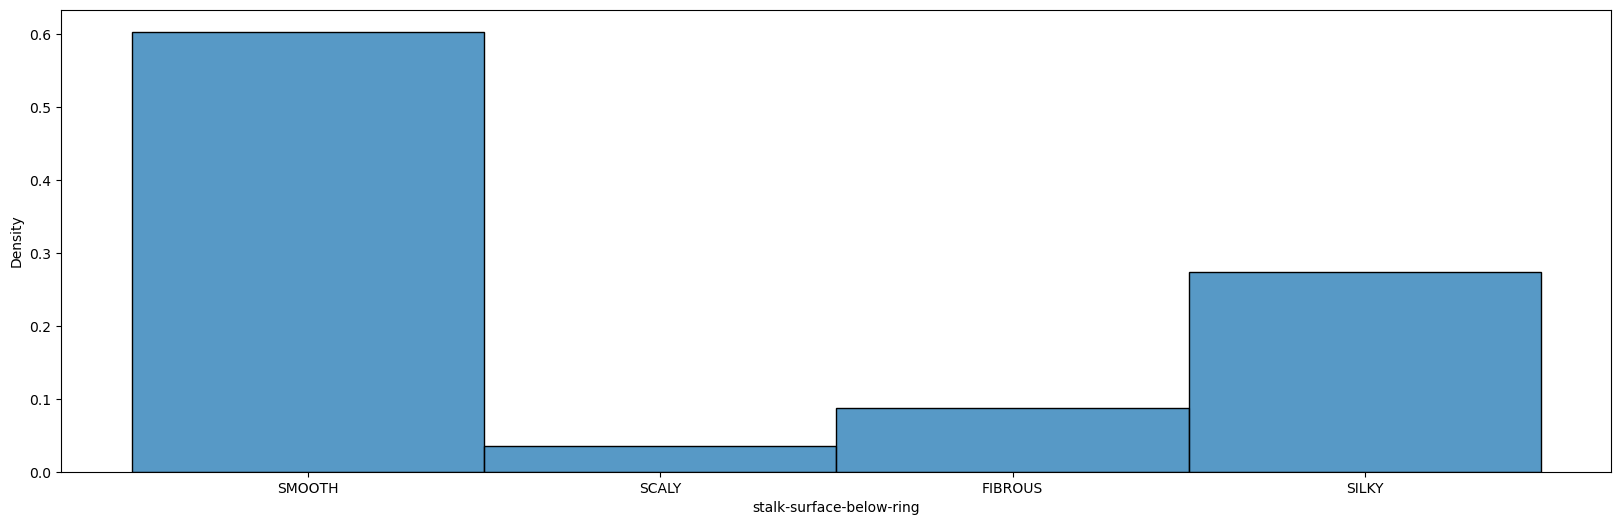

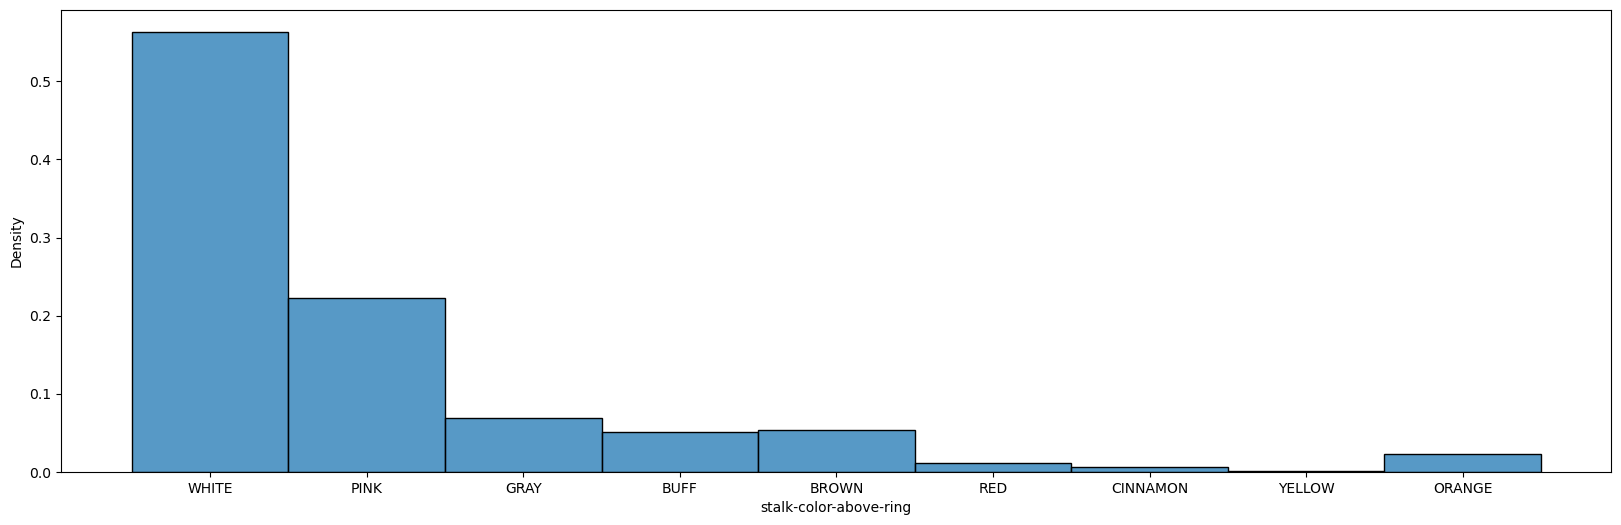

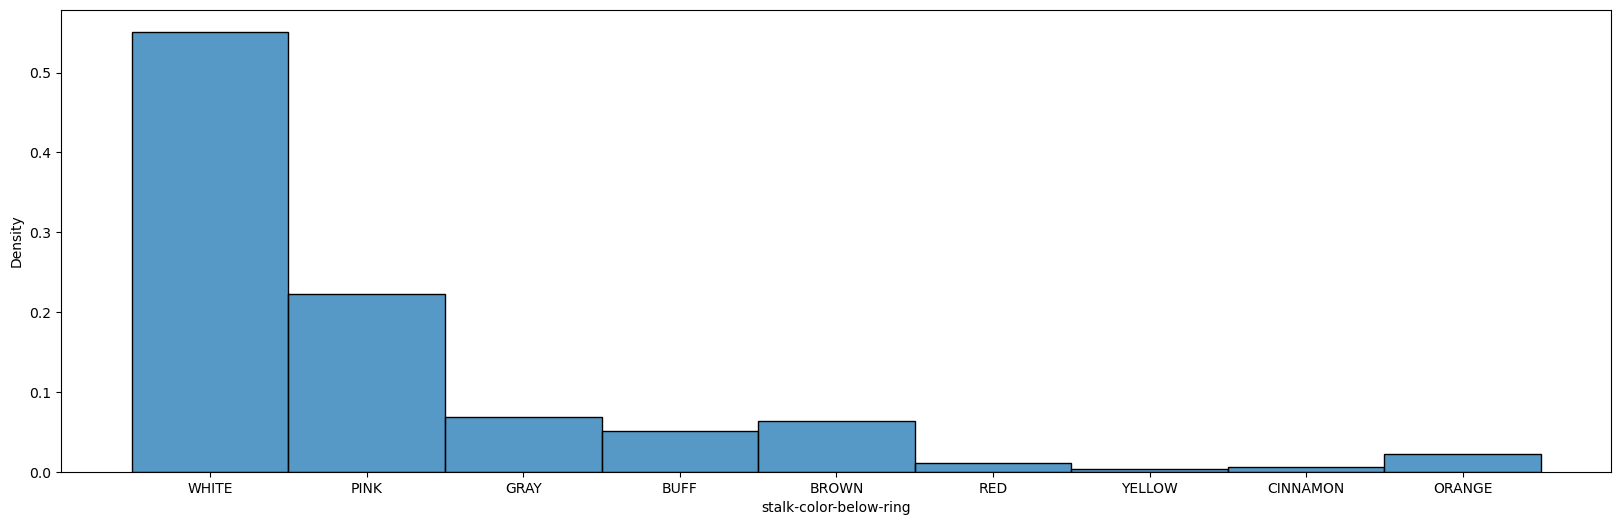

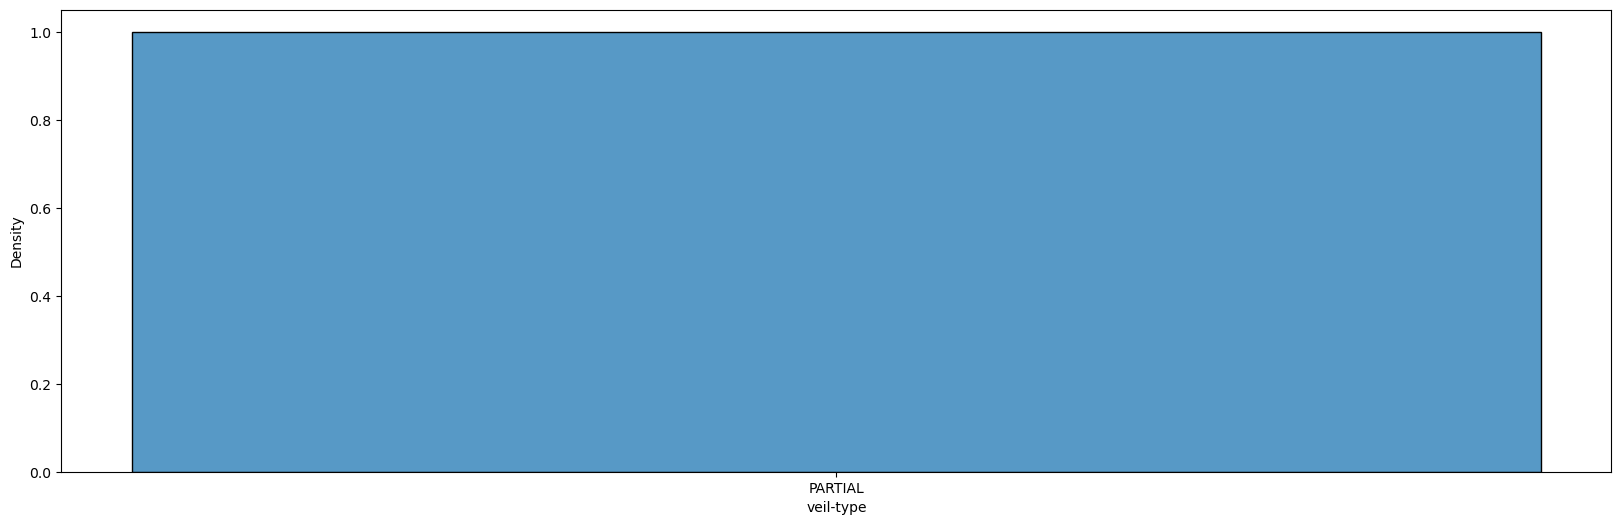

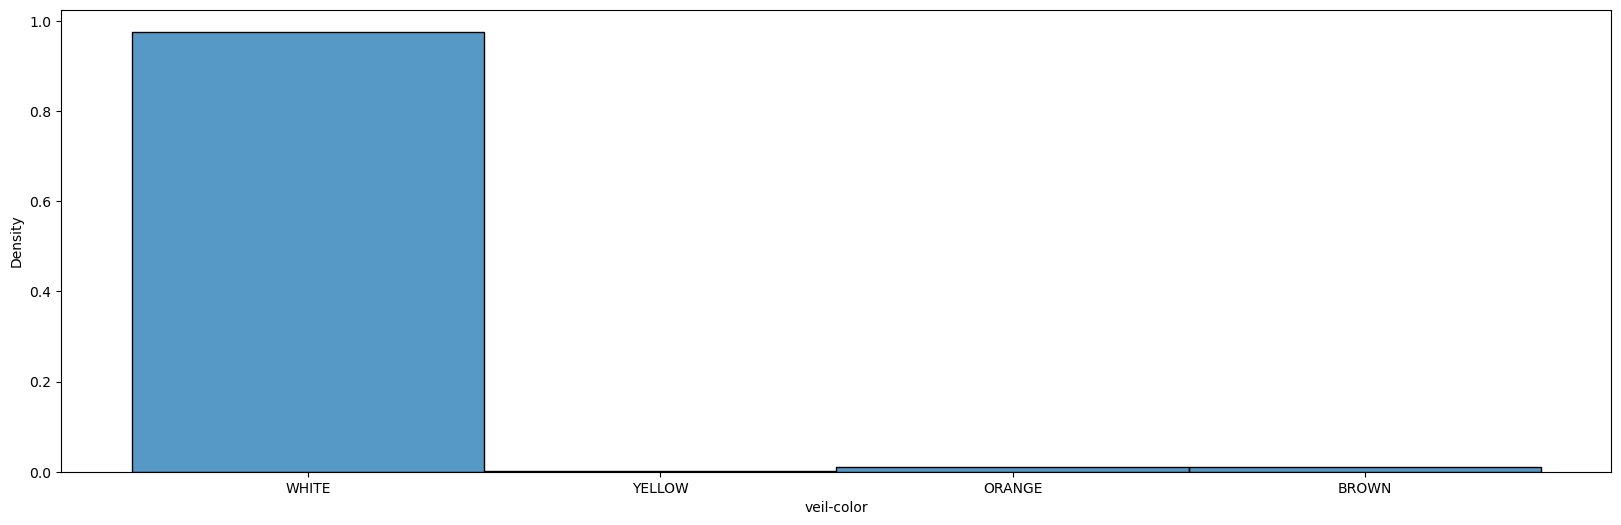

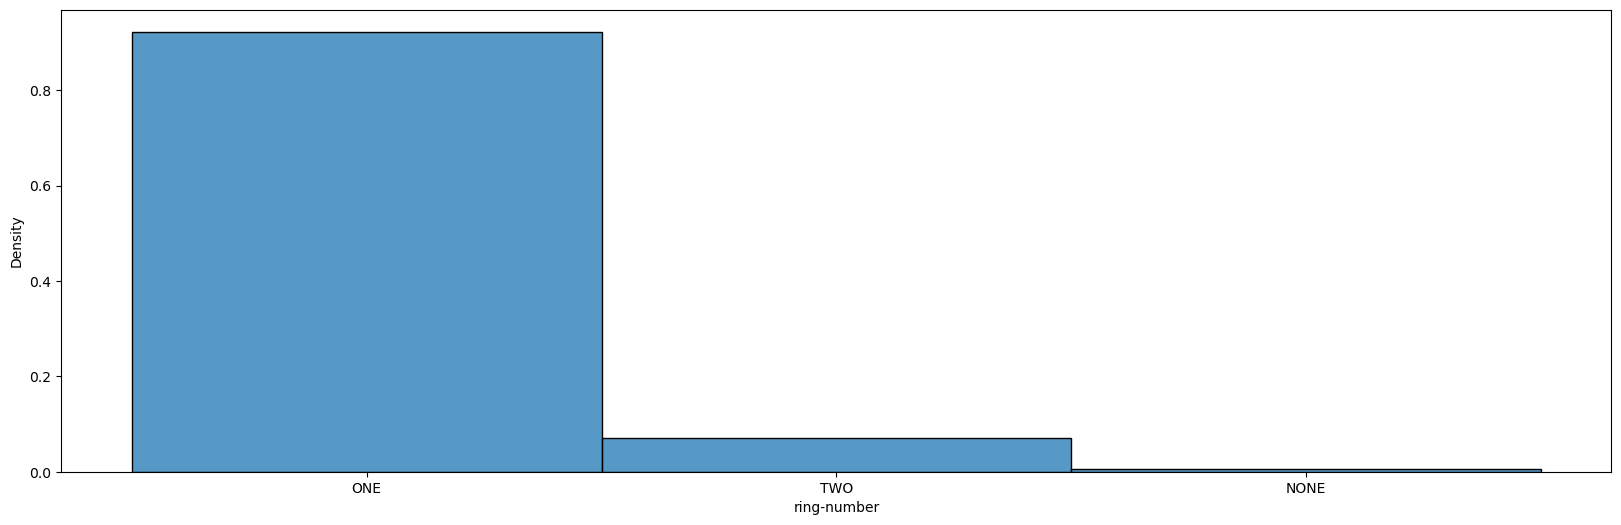

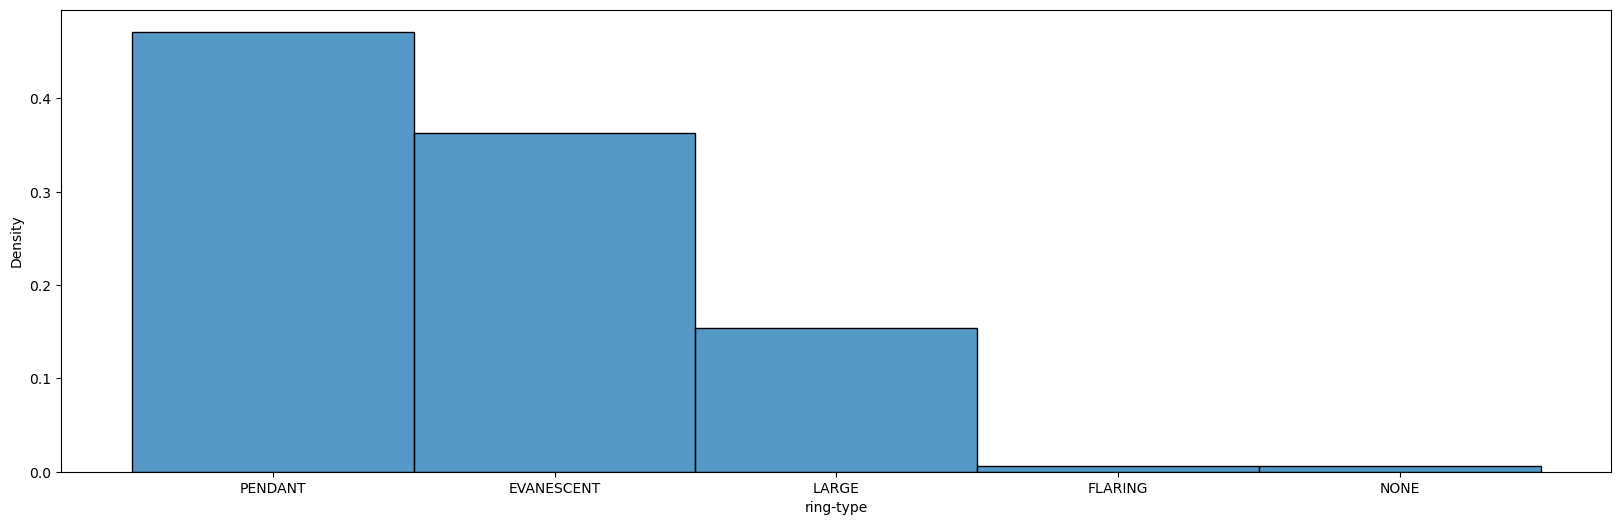

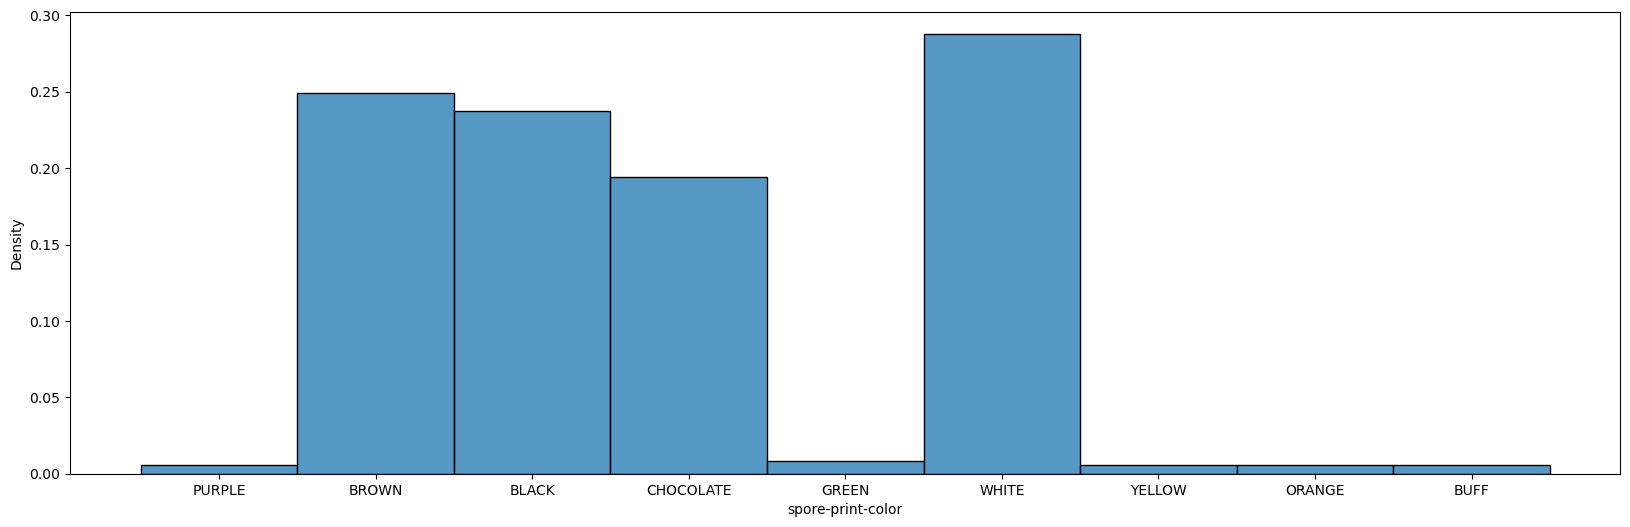

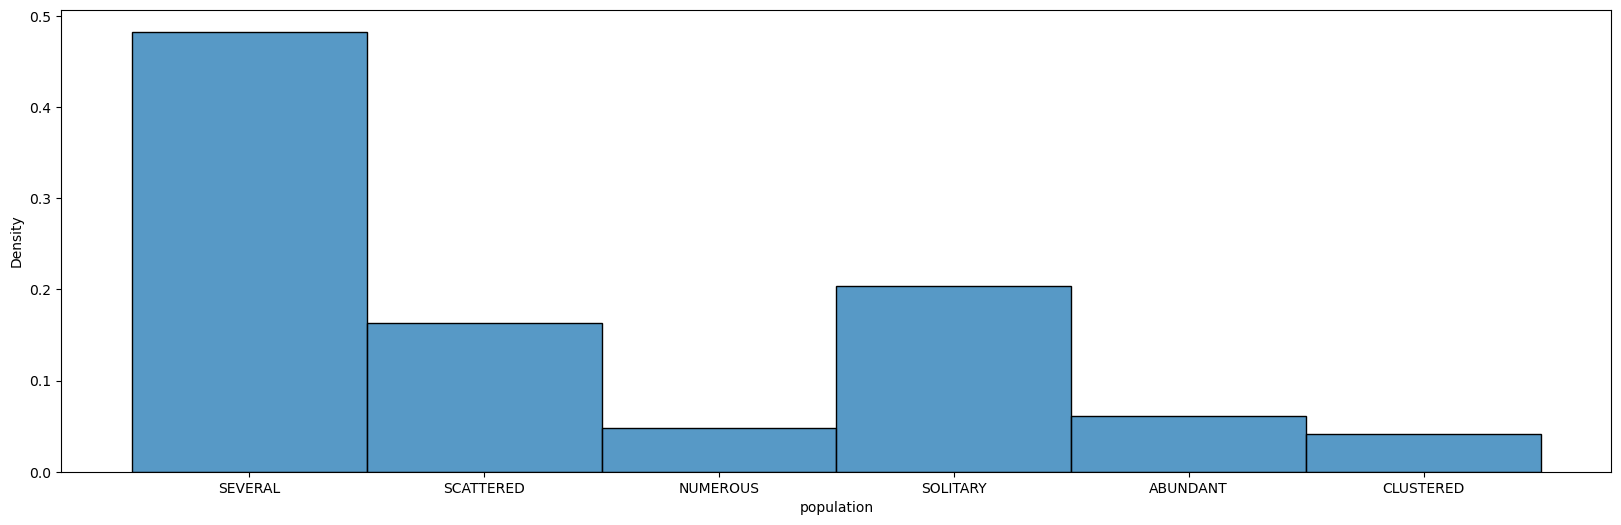

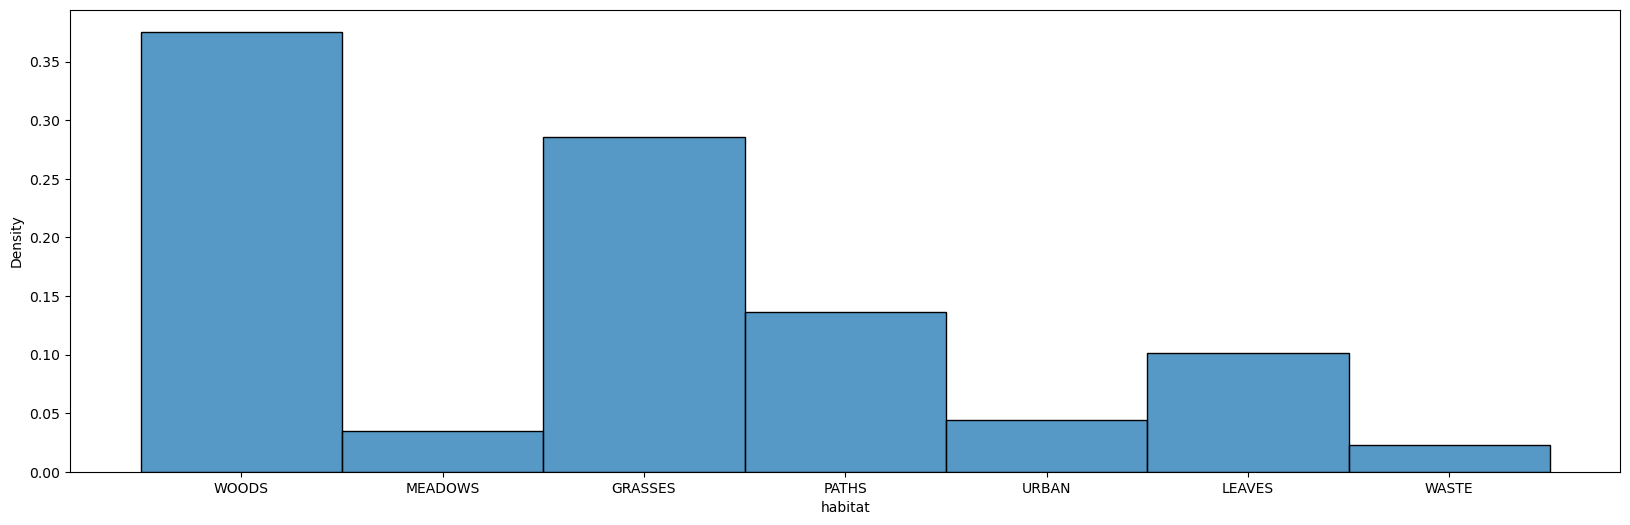

In [7]:
for i in df.columns:
    plt.figure(i)
    sns.histplot(df[i],stat="density")
    plt.show()

In [8]:
pd.crosstab(df['stalk-root'], df['class-label'], normalize='index')

class-label,EDIBLE,POISONOUS
stalk-root,,
?,0.290323,0.709677
BULBOUS,0.511579,0.488421
CLUB,0.901408,0.098592
EQUAL,0.813953,0.186047
ROOTED,1.000000,0.000000


Хотя некоторые значения (`ROOTED`, `CLUB`) почти всегда соответствуют съедобным грибам, признак содержит **30% пропусков** (`?`), а наиболее частое значение (`BULBOUS`) не разделяет классы (51% / 49%). 

Исходя из анализа данных, было принято решение удалить два признака:

1. **`veil-type`** — содержит только одно уникальное значение (`'partial'`) во всём датасете.  
   Такой признак является константой и не несёт никакой информации для разделения классов, поэтому его удаление упрощает модель без потери качества.

2. **`stalk-root`** — содержит большое количество пропущенных значений (обозначены как `'?'`), что составляет около 30% от всех наблюдений.  
   Заполнение или удаление таких строк привело бы либо к смещению данных, либо к значительной потере объёма выборки.  
   Кроме того, даже при наличии значения этот признак слабо коррелирует с целевой переменной.  
   Поэтому он также был удалён как малоинформативный и ненадёжный.

## Предобработка данных

In [9]:
df = df.drop(columns=['veil-type', 'stalk-root'])

Преобразуем метки классов в числа

In [10]:
y = (df['class-label'] == 'POISONOUS').astype(int).values
X = df.drop('class-label', axis=1)

Применяем one-hot encoding для всех категориальных пизнаков

In [11]:
X_encoded = pd.get_dummies(X, dtype=float)
X = X_encoded.values

Разделяем на train/test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
X_train.shape

(6732, 111)

## Реализация MLP с 2-мя скрытыми слоями

В лекции приводится обобщённая форма логистической функции активации (сигмоиды): 
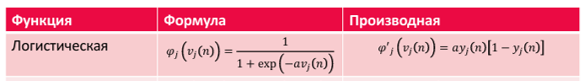

где параметр `a` управляет наклоном:

при `a > 1` — функция становится круче, при `0 < a < 1` — более пологой, при `a = 1` — получаем стандартную сигмоиду, которая чаще встречается на практике, следовательно наша сигмоида будет иметь вид:

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [15]:
def sigmoid_derivative(z):
    s = sigmoid(z)  # s = φ(z) -> это y_j(n)
    return s * (1 - s)  # s*(1-s) = y_j(n)*(1 - y_j(n))

### Инициализируем вес

In [16]:
input_size = X_train.shape[1]   # количество признаков после one-hot
hidden1_size = 64               # размер 1-го скрытого слоя
hidden2_size = 32               # размер 2-го скрытого слоя
output_size = 2                 # 2 класса -> 2 выходных нейрона

In [17]:
W1 = rng.normal(0, 0.1, (input_size, hidden1_size))      # вход -> скрытый 1
b1 = np.zeros((1, hidden1_size))

W2 = rng.normal(0, 0.1, (hidden1_size, hidden2_size))    # скрытый 1 -> скрытый 2
b2 = np.zeros((1, hidden2_size))

W3 = rng.normal(0, 0.1, (hidden2_size, output_size))     # скрытый 2 -> выход
b3 = np.zeros((1, output_size))

### Прямой проход

Напишем функцию вычисления выходных значений нейронной сети для входных данных путем последовательного прохождения через все слои

In [18]:
def forward(X, W1, b1, W2, b2, W3, b3):
    # слой 1
    z1 = X @ W1 + b1
    a1 = sigmoid(z1)
    # слой 2
    z2 = a1 @ W2 + b2
    a2 = sigmoid(z2)
    # выходной слой
    z3 = a2 @ W3 + b3
    a3 = sigmoid(z3)
    return z1, a1, z2, a2, z3, a3

*Первый скрытый слой*
- умножаем входные данные на веса первого слоя и добавляем смещения
- применяем функцию активации (сигмоиду) к результату
- получаем активации первого скрытого слоя

*Второй скрытый слой*
- берем активации первого слоя как входные данные
- умножаем на веса второго слоя и добавляем смещения
- снова применяем функцию активации
- получаем активации второго скрытого слоя

*Выходной слой*
- используем активации второго слоя как входные данные
- умножаем на веса выходного слоя и добавляем смещения
- применяем функцию активации для получения финального результата
- получаем предсказания сети для двух классов

Функция возвращает все промежуточные результаты (взвешенные суммы и активации каждого слоя), которые сохраняются для использования при обратном распространении ошибки.

### Обратное распространение ошибки

Теперь создадим функцию для определения, в каком направлении и насколько сильно нужно изменить каждый параметр сети (веса и смещения), чтобы уменьшить ошибку предсказания.

In [19]:
def backward(X, y_true, z1, a1, z2, a2, z3, a3, W2, W3):
    batch_size = X.shape[0]
    # целевой вектор, one-hot кодирование
    y_onehot = np.zeros_like(a3)
    y_onehot[np.arange(batch_size), y_true] = 1
    # ошибка на выходе
    e = y_onehot - a3
   
    # локальный градиент выходного слоя
    delta3 = e * sigmoid_derivative(z3)
    # градиенты для W3, b3
    dW3 = a2.T @ delta3/batch_size
    db3 = np.sum(delta3, axis=0, keepdims=True)/batch_size
    
    # локальный градиент 2-го скрытого слоя
    delta2 = (delta3 @ W3.T)*sigmoid_derivative(z2)
    dW2 = a1.T @ delta2/batch_size
    db2 = np.sum(delta2, axis=0, keepdims=True)/batch_size
   
    # локальный градиент 1-го скрытого слоя
    delta1 = (delta2 @ W2.T) * sigmoid_derivative(z1)
    dW1 = X.T @ delta1 / batch_size
    db1 = np.sum(delta1, axis=0, keepdims=True)/batch_size

    return dW1, db1, dW2, db2, dW3, db3

Функция backward выполняет обратное распространение ошибки

Сначала функция преобразует правильные ответы в one hot encoding. Если у нас два класса (например, "съедобный" и "ядовитый"), то для съедобного гриба создается вектор [1, 0], а для ядовитого - [0, 1]. 

Затем вычисляет разницу между тем, что должно было получиться, и тем, что фактически предсказала сеть. Эта разница представляет собой ошибку предсказания для каждого примера в обучающем наборе.


*Расчет градиентов для выходного слоя*

Здесь вычисляем, насколько каждый выходной нейрон виноват в общей ошибке
- локальный градиент показывает, насколько чувствительна ошибка к изменениям входного сигнала каждого выходного нейрона
- полные градиенты определяют, как именно нужно изменить веса и смещения выходного слоя

Для вычисления градиентов весов используется транспонирование активаций предыдущего слоя, что позволяет правильно сопоставить каждый вход с соответствующей ошибкой

*Распространение ошибки на второй скрытый слой*

Ошибка передается назад на второй скрытый слой. Для этого

- определяем, какой вклад каждый нейрон скрытого слоя внес в ошибку выходного слоя
- учитываем насколько чувствителен каждый скрытый нейрон к изменениям своего входного сигнала

Далее вычисляем градиенты для обновления весов и смещений этого слоя

*Распространение ошибки на первый скрытый слой*

Аналогичным образом передаем ошибку на первый скрытый слой
- определяем влияние каждого нейрона первого слоя на ошибку второго слоя
- вычисляем чувствительность нейронов к входным сигналам

Рассчитываются окончательные градиенты для весов и смещений первого слоя

Функция возвращает набор градиентов для всех параметров сети, которые используются в алгоритме градиентного спуска для постепенного улучшения точности предсказаний сети на каждой итерации.

## Обучение

Последовательно обучим нейронную сеть на множестве эпох, постепенно улучшая её точность предсказаний

In [20]:
epochs = 100
learning_rate = 0.1
batch_size = 32
train_losses = []
test_losses = []

Сначала перемешаем наши обучающие данные и разобъем их на батчи.

Далее пройдемся по каждому батчу:
- выполняем прямой проход, пропускаем данные через сеть и получаем предсказания
- преобразуем правильные ответы в формат двух нейронов ([1,0] или [0,1])
- вычисляем ошибку предсказания на текущем батче
- выполняем обратное распространение, определяем направления изменения весов
- обновляем все параметры сети с заданной скоростью обучения

После каждой эпохи вычисляем среднюю ошибку на обучающих данных и проверяем качество сети на тестовых данных без обновления весов. Сохраняем значения ошибок для анализа сходимости.

In [21]:
for epoch in range(epochs):
    indices = np.arange(X_train.shape[0])
    rng.shuffle(indices)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    epoch_train_loss = 0
    num_train_batches = 0

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        # прямой проход
        z1, a1, z2, a2, z3, a3 = forward(X_batch, W1, b1, W2, b2, W3, b3)

        # one-hot для MSE
        y_onehot = np.zeros_like(a3)
        y_onehot[np.arange(len(y_batch)), y_batch] = 1

        # потеря на батче
        loss = np.mean(0.5 * np.sum((y_onehot - a3)**2, axis=1))
        epoch_train_loss += loss
        num_train_batches += 1

        # обратное распространение и обновление весов
        dW1, db1, dW2, db2, dW3, db3 = backward(X_batch, y_batch, z1, a1, z2, a2, z3, a3, W2, W3)
        W1 += learning_rate*dW1
        b1 += learning_rate*db1
        W2 += learning_rate*dW2
        b2 += learning_rate*db2
        W3 += learning_rate*dW3
        b3 += learning_rate*db3

    avg_train_loss = epoch_train_loss/num_train_batches
    train_losses.append(avg_train_loss)
    
    _, _, _, _, _, a3_test = forward(X_test, W1, b1, W2, b2, W3, b3)
    y_onehot_test = np.zeros_like(a3_test)
    y_onehot_test[np.arange(len(y_test)), y_test] = 1
    test_loss = np.mean(0.5 * np.sum((y_onehot_test - a3_test)**2, axis=1))
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch   0 | Train Loss: 0.24796 | Test Loss: 0.24772
Epoch  10 | Train Loss: 0.03521 | Test Loss: 0.02958
Epoch  20 | Train Loss: 0.01584 | Test Loss: 0.01339
Epoch  30 | Train Loss: 0.01088 | Test Loss: 0.00987
Epoch  40 | Train Loss: 0.00495 | Test Loss: 0.00649
Epoch  50 | Train Loss: 0.00309 | Test Loss: 0.00512
Epoch  60 | Train Loss: 0.00204 | Test Loss: 0.00430
Epoch  70 | Train Loss: 0.00150 | Test Loss: 0.00386
Epoch  80 | Train Loss: 0.00122 | Test Loss: 0.00361
Epoch  90 | Train Loss: 0.00104 | Test Loss: 0.00346


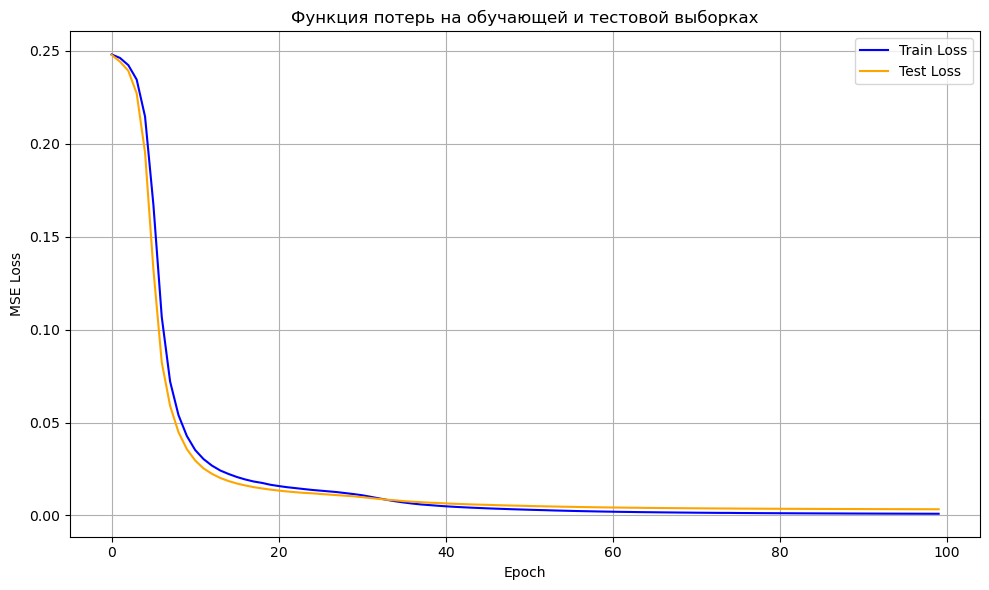

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Функция потерь на обучающей и тестовой выборках')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ошибка последовательно уменьшается на обеих выборках. Нет резких скачков, что свидетельствует о стабильном обучении.

Кривые обучающей и тестовой ошибок идут близко друг к другу. Тестовая ошибка даже немного ниже обучающей в конце обучения. Это указывает на хорошую обобщающую способность модели.

Основное уменьшение ошибки происходит в первые 20 эпох. После 40й эпохи ошибка стабилизируется

In [23]:
_, _, _, _, _, a3_test = forward(X_test, W1, b1, W2, b2, W3, b3)
y_pred = np.argmax(a3_test, axis=1)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

Accuracy:  0.9970
Precision: 1.0000
Recall:    0.9936
F1-score:  0.9968


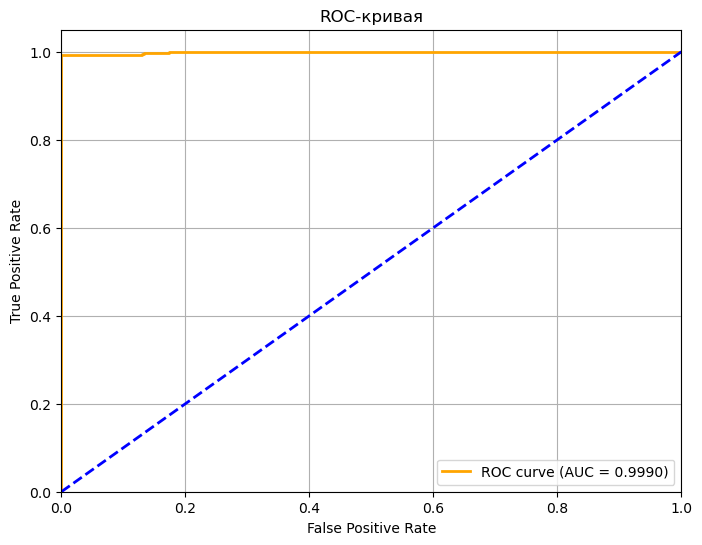

In [24]:
y_score = a3_test[:, 1]  # вероятность ядовитый
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

ROC-кривая подтверждает высокое качество обученной нейронной сети. Модель практически идеально решает поставленную задачу классификации грибов.

## Сравнительный анализ

Проведем сравнительный анализ разного размера архиетктур

Проверим 7 конфигураций: 

- (16, 8) — минимальная сеть
- (32, 16), (64, 32) — базовые
- (128, 64), (256, 128) — большие (риск переобучения)
- (64, 16) — «бутылочное горлышко»
- (32, 32) — симметричная

In [25]:
df = pd.read_csv('2. Mushroom_dataset', delimiter = ",", names=['class-label','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat'])

In [26]:
df_clean = df.drop(['veil-type', 'stalk-root'], axis=1)

y = (df_clean['class-label'] == 'POISONOUS').astype(int).values
X = df_clean.drop('class-label', axis=1)
X_encoded = pd.get_dummies(X, dtype=float)
X = X_encoded.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
def train_architecture(hidden1_size, hidden2_size, X_train, y_train, X_test, y_test, epochs=100, learning_rate=0.1, batch_size=32):
    input_size = X_train.shape[1]
    output_size = 2
    W1 = rng.normal(0, 0.1, (input_size, hidden1_size))
    b1 = np.zeros((1, hidden1_size))
    W2 = rng.normal(0, 0.1, (hidden1_size, hidden2_size))
    b2 = np.zeros((1, hidden2_size))
    W3 = rng.normal(0, 0.1, (hidden2_size, output_size))
    b3 = np.zeros((1, output_size))
    
    train_losses = []
    test_losses = []
    start_time = time.time()
    
    for epoch in range(epochs):
        indices = np.arange(X_train.shape[0])
        rng.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        epoch_train_loss = 0
        num_train_batches = 0

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # прямой проход
            z1, a1, z2, a2, z3, a3 = forward(X_batch, W1, b1, W2, b2, W3, b3)

            # one-hot для MSE
            y_onehot = np.zeros_like(a3)
            y_onehot[np.arange(len(y_batch)), y_batch] = 1

            # потеря на батче
            loss = np.mean(0.5 * np.sum((y_onehot - a3)**2, axis=1))
            epoch_train_loss += loss
            num_train_batches += 1

            # обратное распространение и обновление весов
            dW1, db1, dW2, db2, dW3, db3 = backward(X_batch, y_batch, z1, a1, z2, a2, z3, a3, W2, W3)

            W1 += learning_rate*dW1
            b1 += learning_rate*db1
            W2 += learning_rate*dW2
            b2 += learning_rate*db2
            W3 += learning_rate*dW3
            b3 += learning_rate*db3

        avg_train_loss = epoch_train_loss / num_train_batches
        train_losses.append(avg_train_loss)
        
        _, _, _, _, _, a3_test = forward(X_test, W1, b1, W2, b2, W3, b3)
        y_onehot_test = np.zeros_like(a3_test)
        y_onehot_test[np.arange(len(y_test)), y_test] = 1
        test_loss = np.mean(0.5 * np.sum((y_onehot_test - a3_test)**2, axis=1))
        test_losses.append(test_loss)
    
    training_time = time.time() - start_time
    _, _, _, _, _, a3_test = forward(X_test, W1, b1, W2, b2, W3, b3)
    y_pred = np.argmax(a3_test, axis=1)
    y_score = a3_test[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    num_params = (W1.size + b1.size + W2.size + b2.size + W3.size + b3.size)
    
    return {
        'architecture': (hidden1_size, hidden2_size),
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'auc': roc_auc,
        'training_time': training_time,
        'num_params': num_params,
        'weights': (W1, b1, W2, b2, W3, b3)
    }

In [28]:
architectures = [(16, 8), (32, 16), (64, 32), (128, 64), (256, 128), (64, 16), (32, 32)]

In [29]:
results = []
for i, (h1, h2) in enumerate(architectures):
    print(f"Обучение архитектуры {i+1}: ({h1}, {h2})")
    result = train_architecture(h1, h2, X_train, y_train, X_test, y_test, epochs=100)
    results.append(result)
    print(f"  Accuracy:  {result['accuracy']:.4f}")
    print(f"  F1-score:  {result['f1_score']:.4f}")
    print(f"  AUC:       {result['auc']:.4f}")
    print(f"  Время:     {result['training_time']:.2f} сек")
    print(f"  Параметры: {result['num_params']}")
    print("-" * 50)

Обучение архитектуры 1: (16, 8)
  Accuracy:  0.9970
  F1-score:  0.9968
  AUC:       0.9993
  Время:     5.72 сек
  Параметры: 1946
--------------------------------------------------
Обучение архитектуры 2: (32, 16)
  Accuracy:  0.9970
  F1-score:  0.9968
  AUC:       0.9994
  Время:     6.73 сек
  Параметры: 4146
--------------------------------------------------
Обучение архитектуры 3: (64, 32)
  Accuracy:  0.9970
  F1-score:  0.9968
  AUC:       0.9992
  Время:     8.12 сек
  Параметры: 9314
--------------------------------------------------
Обучение архитектуры 4: (128, 64)
  Accuracy:  0.9970
  F1-score:  0.9968
  AUC:       0.9989
  Время:     11.56 сек
  Параметры: 22722
--------------------------------------------------
Обучение архитектуры 5: (256, 128)
  Accuracy:  0.9970
  F1-score:  0.9968
  AUC:       0.9989
  Время:     20.59 сек
  Параметры: 61826
--------------------------------------------------
Обучение архитектуры 6: (64, 16)
  Accuracy:  0.9970
  F1-score:  0.9968
 

In [30]:
print(f"{'Архитектура':<15} {'Accuracy':<10} {'F1-score':<10} {'AUC':<10} {'Время (сек)':<10} {'Параметры':<15}")
print("-" * 100)
for result in results:
    arch = f"({result['architecture'][0]}, {result['architecture'][1]})"
    print(f"{arch:<15} {result['accuracy']:<10.4f} {result['f1_score']:<10.4f} "
          f"{result['auc']:<10.4f} {result['training_time']:<10.2f} {result['num_params']:<15}")

Архитектура     Accuracy   F1-score   AUC        Время (сек) Параметры      
----------------------------------------------------------------------------------------------------
(16, 8)         0.9970     0.9968     0.9993     5.72       1946           
(32, 16)        0.9970     0.9968     0.9994     6.73       4146           
(64, 32)        0.9970     0.9968     0.9992     8.12       9314           
(128, 64)       0.9970     0.9968     0.9989     11.56      22722          
(256, 128)      0.9970     0.9968     0.9989     20.59      61826          
(64, 16)        0.9970     0.9968     0.9990     8.39       8242           
(32, 32)        0.9970     0.9968     0.9994     7.28       4706           


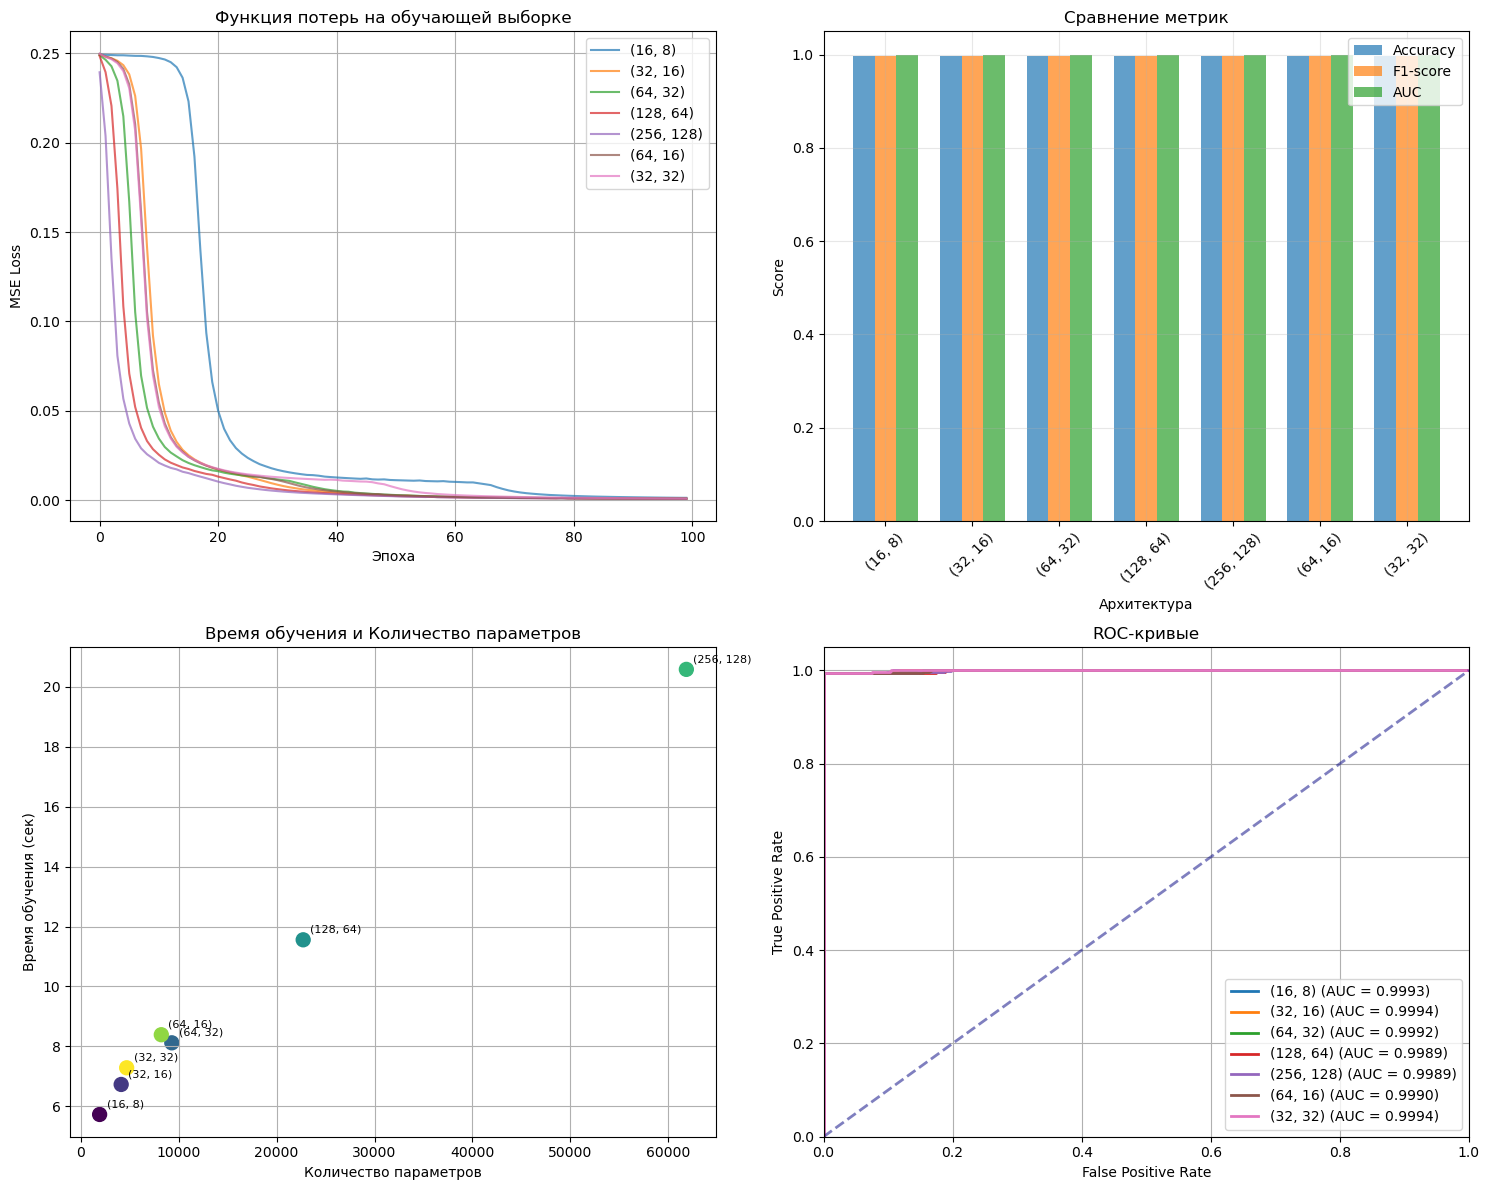

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# график потерь для разных архитектур
for result in results:
    arch_label = f"({result['architecture'][0]}, {result['architecture'][1]})"
    axes[0, 0].plot(result['train_losses'], label=arch_label, alpha=0.7)

axes[0, 0].set_title('Функция потерь на обучающей выборке')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# сравнение метрик
arch_names = [f"({r['architecture'][0]}, {r['architecture'][1]})" for r in results]
accuracies = [r['accuracy'] for r in results]
f1_scores = [r['f1_score'] for r in results]
auc_scores = [r['auc'] for r in results]

x = np.arange(len(arch_names))
width = 0.25

axes[0, 1].bar(x - width, accuracies, width, label='Accuracy', alpha=0.7)
axes[0, 1].bar(x, f1_scores, width, label='F1-score', alpha=0.7)
axes[0, 1].bar(x + width, auc_scores, width, label='AUC', alpha=0.7)

axes[0, 1].set_title('Сравнение метрик')
axes[0, 1].set_xlabel('Архитектура')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(arch_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# время обучения и параметры
training_times = [r['training_time'] for r in results]
num_params = [r['num_params'] for r in results]

scatter = axes[1, 0].scatter(num_params, training_times, s=100, c=range(len(results)), cmap='viridis')
axes[1, 0].set_title('Время обучения и Количество параметров')
axes[1, 0].set_xlabel('Количество параметров')
axes[1, 0].set_ylabel('Время обучения (сек)')
axes[1, 0].grid(True)

for i, (params, time_val) in enumerate(zip(num_params, training_times)):
    axes[1, 0].annotate(arch_names[i], (params, time_val), xytext=(5, 5), 
                       textcoords='offset points', fontsize=8)

# ROC-кривые
for result in results:
    arch_label = f"({result['architecture'][0]}, {result['architecture'][1]})"
    _, _, _, _, _, a3_test = forward(X_test, *result['weights'])
    y_score = a3_test[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, lw=2, label=f'{arch_label} (AUC = {roc_auc:.4f})')

axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC-кривые')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()